In [3]:
import os
import sys
import time
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
from scipy.signal import welch, firwin, filtfilt, hilbert
from time import gmtime

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
sys.path.insert(0, '/Users/vasilyminkov/Scripts/Python3/')

from Neuroinformatics.torpor_project.data import *
from Neuroinformatics.math.pandas.statistics import *
from Neuroinformatics.data.pandas.time_series import TimeSeries
from Neuroinformatics.math.curves import *
from Neuroinformatics.math.regression import *

/Users/vasilyminkov/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [6]:
pylab.rcParams['figure.figsize'] = (22, 18)
sns.set(font_scale=2.5)

In [6]:
paths = {}
for folder in os.walk(path):
    key = folder[0].split(os.path.sep)[-1]
    li = []
    for file in folder[2:][0]:
        if file.split('.')[-1] == "bdf":
            li.append(os.path.join(folder[0], file))
    if len(li) > 0:
        paths[key] = li

In [18]:
for key, value in paths.items():
    print(key, value[1].split('/')[-1][:-10])

RecV3_2_ang+ 31-01-2019
RecV3_3_ang+ 31-01-2019
RecV3_4_ang+ 31-01-2019
RecV3_1_ang- 31-01-2019


In [19]:
min_per_epoch = 1
order = 400 # filter order
a = 1 
bands = np.array([[1, 4], [4, 8]]) 
chans = ["Channel 1", "Channel 2"]
kinds = ["Power",
         "Power {}-{}".format(bands[0,0], bands[0,1]), 
         "Power {}-{}".format(bands[1,0], bands[1,1]),
        ]

data = []
for chan in chans:
    for kind in kinds:
        data.append("{} {}".format(chan, kind))        
data.append("Acceleration")
data.append("Subject")
data.append("Record")

data = pd.DataFrame(columns=data)

start_epoc = 0
counter = 0

for key, value in paths.items():
    for name in value:

        # read EEG and acceleration data
        raw_data = mne.io.read_raw_edf(name)
            
        fs = round(raw_data.info['sfreq'])
        df = pd.DataFrame(raw_data.get_data().T, columns=raw_data.info["ch_names"])        

#         if name == "/Users/wassilyminkow/Data/Hamster_Data/hamster_lactate/1_D-L/RecV3_1_ang-/01-02-2019_14-21.bdf":
#             df = df.iloc[:, 100000:200000]
        
        # Calculate # of polygraphy epochs and correspotding # of EEG samples for the  EEG file
        n_epocs = int(np.floor(df.shape[0]/fs/SEC_PER_MIN/min_per_epoch))
        n_samples = int(n_epocs*min_per_epoch*SEC_PER_MIN*fs)

        # Skip damaged samples at the ending
        df_epocs = df.iloc[:n_samples, :]

        # Polygraphy epoch length in EEG samples.
        step = fs*SEC_PER_MIN*min_per_epoch

        data_new = {}
        
#         n = 0
        for chan in chans:

            # low-pass filter
            b = firwin(order, bands[0, :] * 2 / fs, width=None, window='hamming', pass_zero=False) # design filter
            df_epocs_lo = filtfilt(b, a, df_epocs[chan].iloc[:]) # apply filter
            
            # high-pass filter
            b = firwin(order, bands[1, :] * 2 / fs, width=None, window='hamming', pass_zero=False) # design filter
            df_epocs_hi = filtfilt(b, a, df_epocs[chan].iloc[:])
            
#             n+=1
#             subplot(5,1,n)
#             plot(standardize(df_epocs_hi[1000:15000]), label="{} {}".format(chan, kinds[1]))
#             n+=1
#             subplot(5,1,n)
#             plot(standardize(df_epocs_lo[1000:15000]), label="{} {}".format(chan, kinds[2]))
            
            # band power data
            data_new.update({
                "{} {}".format(chan, kinds[0]): np.array(list(map(lambda i: (df_epocs[chan].iloc[i*step:(i+1)*step]**2).mean(), np.arange(n_epocs)))),
                "{} {}".format(chan, kinds[1]): np.array(list(map(lambda i: (df_epocs_lo[i*step:(i+1)*step]**2).mean(), np.arange(n_epocs)))),
                "{} {}".format(chan, kinds[2]): np.array(list(map(lambda i: (df_epocs_hi[i*step:(i+1)*step]**2).mean(), np.arange(n_epocs)))),
            })
            
            del df_epocs_lo, df_epocs_hi

        acc_sign = df_epocs["STI 014"].diff().fillna(0)    
        
        # acceleration data
        data_new.update({
            "Acceleration": np.array(list(map(lambda i: (acc_sign.iloc[i*step:(i+1)*step]**2).mean(), np.arange(n_epocs))))
                        })
        
        data_new = pd.DataFrame(data_new)
        data_new["Subject"] = key
        data_new["Record"] = name.split('/')[-1][:-10]
        
        data = pd.concat([data, data_new])
        
        start_epoc += n_epocs
        counter += 1
        
data = data.reset_index(drop=True)

Extracting EDF parameters from /Users/wassilyminkow/Data/Hamster_Data/hamster_lactate/1_D-L/RecV3_2_ang+/01-02-2019_14-22.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-19-0226a4a4a604>:28: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_data = mne.io.read_raw_edf(name)
/Users/wassilyminkow/anaconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/Users/wassilyminkow/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/wassilyminkow/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: Fu

Extracting EDF parameters from /Users/wassilyminkow/Data/Hamster_Data/hamster_lactate/1_D-L/RecV3_2_ang+/31-01-2019_15-24.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-19-0226a4a4a604>:28: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_data = mne.io.read_raw_edf(name)


Extracting EDF parameters from /Users/wassilyminkow/Data/Hamster_Data/hamster_lactate/1_D-L/RecV3_3_ang+/01-02-2019_14-24.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-19-0226a4a4a604>:28: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_data = mne.io.read_raw_edf(name)


Extracting EDF parameters from /Users/wassilyminkow/Data/Hamster_Data/hamster_lactate/1_D-L/RecV3_3_ang+/31-01-2019_15-28.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-19-0226a4a4a604>:28: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_data = mne.io.read_raw_edf(name)


Extracting EDF parameters from /Users/wassilyminkow/Data/Hamster_Data/hamster_lactate/1_D-L/RecV3_4_ang+/01-02-2019_14-33.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-19-0226a4a4a604>:28: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_data = mne.io.read_raw_edf(name)


Extracting EDF parameters from /Users/wassilyminkow/Data/Hamster_Data/hamster_lactate/1_D-L/RecV3_4_ang+/31-01-2019_15-43.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-19-0226a4a4a604>:28: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_data = mne.io.read_raw_edf(name)


Extracting EDF parameters from /Users/wassilyminkow/Data/Hamster_Data/hamster_lactate/1_D-L/RecV3_1_ang-/01-02-2019_14-21.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-19-0226a4a4a604>:28: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_data = mne.io.read_raw_edf(name)


Extracting EDF parameters from /Users/wassilyminkow/Data/Hamster_Data/hamster_lactate/1_D-L/RecV3_1_ang-/31-01-2019_15-23.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-19-0226a4a4a604>:28: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_data = mne.io.read_raw_edf(name)


In [8]:
data = pd.read_csv("lactate.csv")

In [9]:
data

,Unnamed: 0,Channel 1 Power,Channel 1 Power 1-4,Channel 1 Power 4-8,Channel 2 Power,Channel 2 Power 1-4,Channel 2 Power 4-8,Acceleration,Subject,Record
0,0,0.052778,5.699744e-10,3.160907e-10,0.015787,7.367579e-10,5.668753e-10,1018.953600,RecV3_2_ang+,01-02-2019
1,1,0.053052,5.627204e-10,2.709586e-10,0.015732,7.498979e-10,4.421532e-10,249.270733,RecV3_2_ang+,01-02-2019
2,2,0.053176,6.521131e-10,4.365111e-10,0.015707,9.892243e-10,8.070392e-10,71.134133,RecV3_2_ang+,01-02-2019
3,3,0.052996,7.137406e-10,2.857428e-10,0.015643,1.072749e-09,4.327074e-10,58.265133,RecV3_2_ang+,01-02-2019
4,4,0.052461,4.965823e-10,3.505760e-10,0.015441,5.894226e-10,5.096781e-10,2431.412067,RecV3_2_ang+,01-02-2019
5,5,0.052397,6.400241e-10,4.100222e-10,0.015573,7.990883e-10,5.178795e-10,1077.991733,RecV3_2_ang+,01-02-2019
6,6,0.052448,7.147998e-10,3.276418e-10,0.015723,9.247423e-10,3.948650e-10,100.672333,RecV3_2_ang+,01-02-2019
7,7,0.052396,8.680174e-10,6.323382e-10,0.015658,1.113766e-09,9.107700e-10,97.968933,RecV3_2_ang+,01-02-2019
8,8,0.052122,7.147329e-10,3.058392e-10,0.015672,8.225040e-10,3.967438e-10,11872.065200,RecV3_2_ang+,01-02-2019
9,9,0.052404,5.985720e-10,3.942953e-10,0.015808,8.155583e-10,4.993467e-10,8493.218800,RecV3_2_ang+,01-02-2019


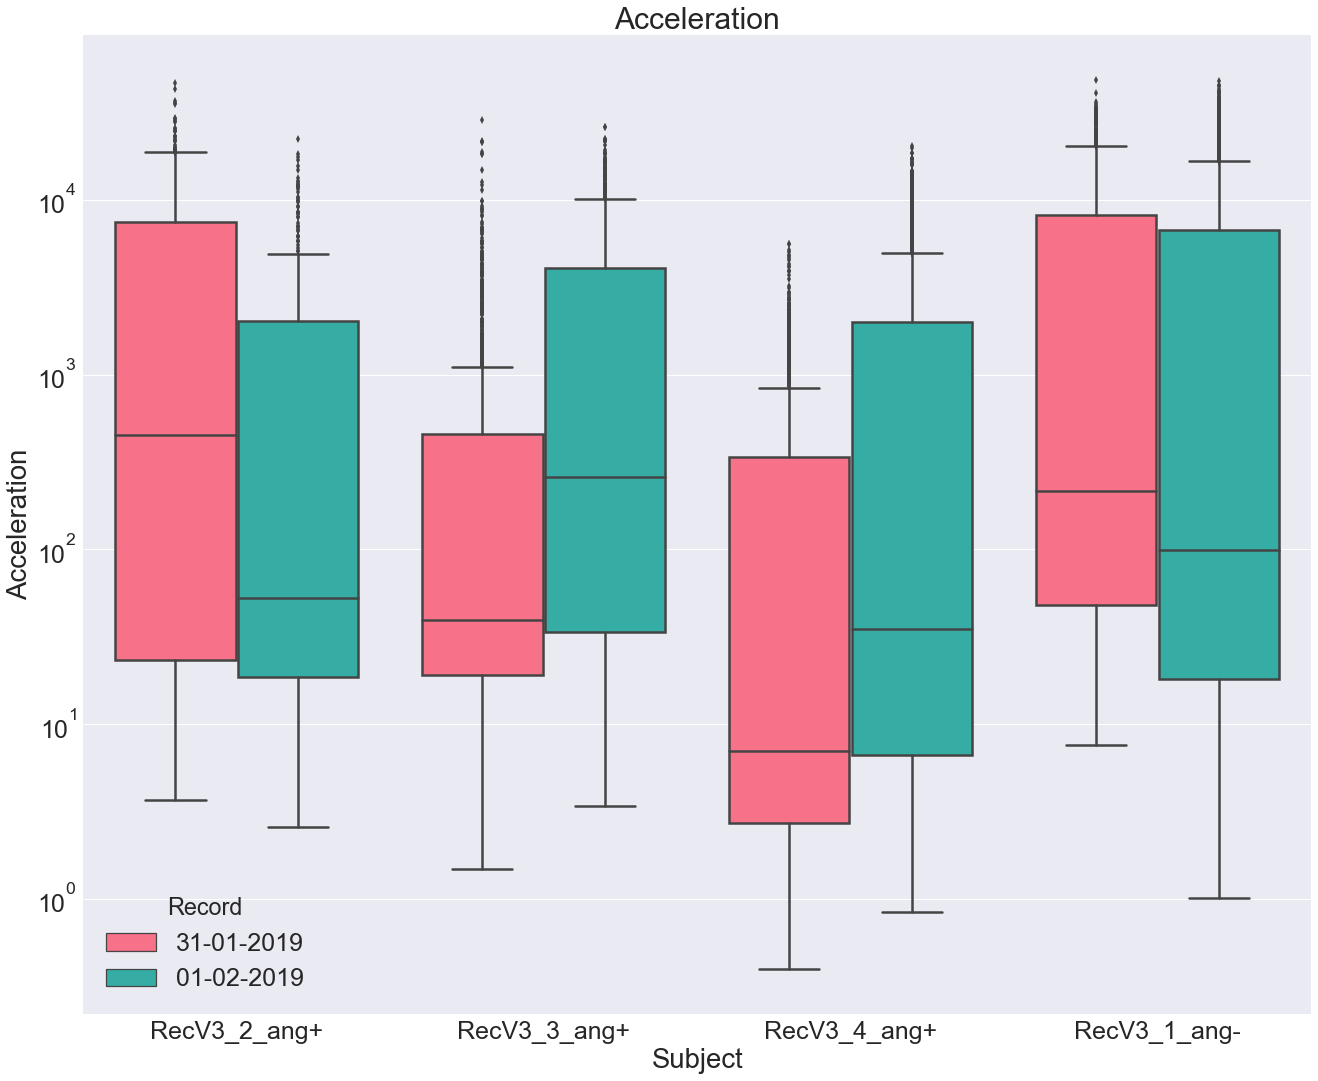

In [10]:
f, ax = plt.subplots()
ax.set(yscale="log")
sns.boxplot(x="Subject", 
            y="Acceleration", 
            hue="Record",
            hue_order=['31-01-2019', '01-02-2019'],
            palette="husl",
            linewidth=2.5,
            saturation=1,
            data=data, 
            ax=ax)
title("Acceleration")
show()

In [19]:
from scipy.stats import wilcoxon
from scipy.stats import ranksums
from statsmodels.sandbox.stats.multicomp import multipletests

In [20]:
paths

{'RecV3_2_ang+': ['/Users/wassilyminkow/Data/Hamster_Data/hamster_lactate/1_D-L/RecV3_2_ang+/01-02-2019_14-22.bdf',
  '/Users/wassilyminkow/Data/Hamster_Data/hamster_lactate/1_D-L/RecV3_2_ang+/31-01-2019_15-24.bdf'],
 'RecV3_3_ang+': ['/Users/wassilyminkow/Data/Hamster_Data/hamster_lactate/1_D-L/RecV3_3_ang+/01-02-2019_14-24.bdf',
  '/Users/wassilyminkow/Data/Hamster_Data/hamster_lactate/1_D-L/RecV3_3_ang+/31-01-2019_15-28.bdf'],
 'RecV3_4_ang+': ['/Users/wassilyminkow/Data/Hamster_Data/hamster_lactate/1_D-L/RecV3_4_ang+/01-02-2019_14-33.bdf',
  '/Users/wassilyminkow/Data/Hamster_Data/hamster_lactate/1_D-L/RecV3_4_ang+/31-01-2019_15-43.bdf'],
 'RecV3_1_ang-': ['/Users/wassilyminkow/Data/Hamster_Data/hamster_lactate/1_D-L/RecV3_1_ang-/01-02-2019_14-21.bdf',
  '/Users/wassilyminkow/Data/Hamster_Data/hamster_lactate/1_D-L/RecV3_1_ang-/31-01-2019_15-23.bdf']}

In [23]:
p_value = np.ones(4)

for i, item in enumerate(paths.items()):
    
    x = data[(data["Subject"]==item[0]) & (data["Record"]=="01-02-2019")]["Acceleration"]
    y = data[(data["Subject"]==item[0]) & (data["Record"]=="31-01-2019")]["Acceleration"]
    
    ss = min(x.shape[0], y.shape[0])
    
    p_value[i] = ranksums(x.sample(ss), y.sample(ss))[1]
    
p_value < 0.05

array([ True,  True,  True,  True])

In [20]:
data

,Unnamed: 0,Channel 1 Power,Channel 1 Power 1-4,Channel 1 Power 4-8,Channel 2 Power,Channel 2 Power 1-4,Channel 2 Power 4-8,Acceleration,Subject,Record,Subject+Record
0,0,0.052778,5.699744e-10,3.160907e-10,0.015787,7.367579e-10,5.668753e-10,1018.953600,RecV3_2_ang+,01-02-2019,RecV3_2_ang+ 01-02-2019
1,1,0.053052,5.627204e-10,2.709586e-10,0.015732,7.498979e-10,4.421532e-10,249.270733,RecV3_2_ang+,01-02-2019,RecV3_2_ang+ 01-02-2019
2,2,0.053176,6.521131e-10,4.365111e-10,0.015707,9.892243e-10,8.070392e-10,71.134133,RecV3_2_ang+,01-02-2019,RecV3_2_ang+ 01-02-2019
3,3,0.052996,7.137406e-10,2.857428e-10,0.015643,1.072749e-09,4.327074e-10,58.265133,RecV3_2_ang+,01-02-2019,RecV3_2_ang+ 01-02-2019
4,4,0.052461,4.965823e-10,3.505760e-10,0.015441,5.894226e-10,5.096781e-10,2431.412067,RecV3_2_ang+,01-02-2019,RecV3_2_ang+ 01-02-2019
5,5,0.052397,6.400241e-10,4.100222e-10,0.015573,7.990883e-10,5.178795e-10,1077.991733,RecV3_2_ang+,01-02-2019,RecV3_2_ang+ 01-02-2019
6,6,0.052448,7.147998e-10,3.276418e-10,0.015723,9.247423e-10,3.948650e-10,100.672333,RecV3_2_ang+,01-02-2019,RecV3_2_ang+ 01-02-2019
7,7,0.052396,8.680174e-10,6.323382e-10,0.015658,1.113766e-09,9.107700e-10,97.968933,RecV3_2_ang+,01-02-2019,RecV3_2_ang+ 01-02-2019
8,8,0.052122,7.147329e-10,3.058392e-10,0.015672,8.225040e-10,3.967438e-10,11872.065200,RecV3_2_ang+,01-02-2019,RecV3_2_ang+ 01-02-2019
9,9,0.052404,5.985720e-10,3.942953e-10,0.015808,8.155583e-10,4.993467e-10,8493.218800,RecV3_2_ang+,01-02-2019,RecV3_2_ang+ 01-02-2019


/Users/vasilyminkov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':
/Users/vasilyminkov/anaconda3/lib/python3.6/site-packages/matplotlib/ticker.py:2207: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "
/Users/vasilyminkov/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/vasilyminkov/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
No handles with labels found to put in legend.
/Users/vasilyminkov/anaconda3/lib/pyt

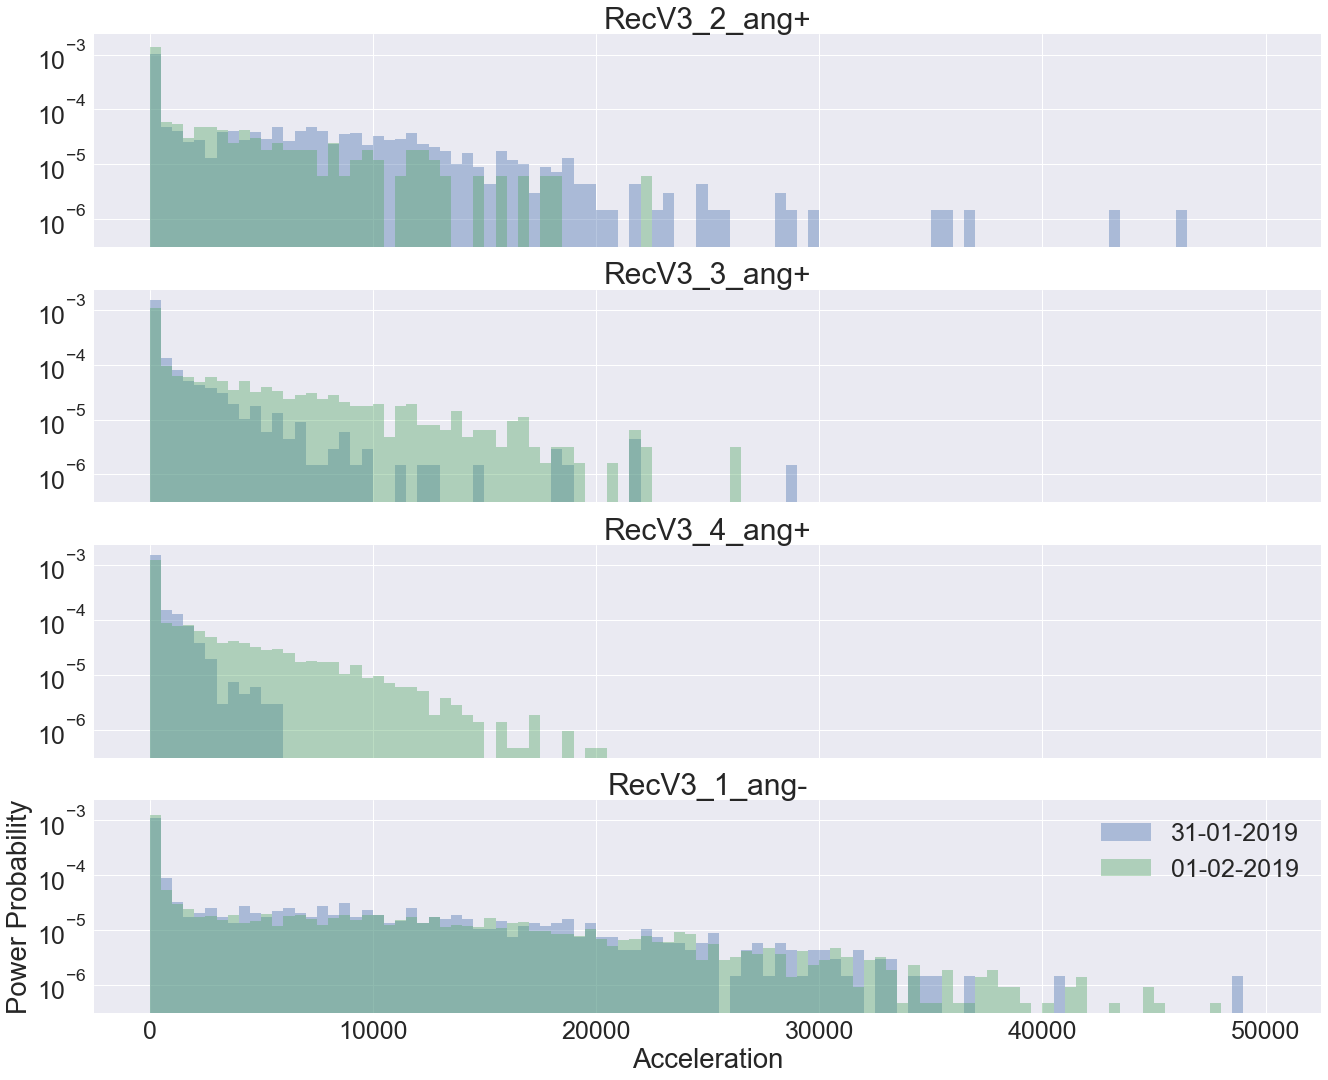

In [18]:
f, ax = plt.subplots(4, 1, sharex=True, sharey=True)

for subject_id, subject_name in enumerate(data["Subject"].unique()):
    
    subject = data[data["Subject"]==subject_name]
    ax[subject_id].set(yscale="log")
    ax[subject_id].set_title(subject_name)
    
    for record_name in subject["Record"].unique()[::-1]:        
        
        sns.distplot(
            subject[subject["Record"]==record_name]["Acceleration"].as_matrix(),
            kde=False,
            bins=100,
            norm_hist=True,
            ax=ax[subject_id],
            hist_kws={"range": [0, 5e4], "label":record_name},
        )
        
    legend()
    xlabel("Acceleration")
    ylabel("Power Probability")